# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.matfile_functions as matlab_fct
import src.features.RT_EOF_functions as rt_eof
import src.set_paths as sps
import src.features.RT_visualise as rtv

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
# output
date_str_start = '201407'
date_str_end = '202207'
fn_version = 'v1'
script_name = '9.0_Paper_Rockall_Trough_Results'

# output figures
fig_out_path = f"C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/{script_name}/"
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# file names
RT_mooring_fn = f'Rockall_Trough_mooring_gridded_TSUV_{date_str_start}_{date_str_end}_{fn_version}.nc'
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_version}.nc"

## Load Data and prepare for calculations

In [5]:
# Load Rockall Trough mooring location
ds_cruises = rtd.load_cruise_list()

# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

#remove nan at beginning and end
ds_RT = ds_RT.where(ds_RT.TG_EAST.sel(PRES=500).notnull().drop_vars('PRES'),drop=True)

# extrapolate upper values of velocity
dim_x = 'TIME'
dim_y = 'PRES'
graphics = False
ds_RT = rtf.extr_moored_RT_timeseries(ds_RT,dim_x,dim_y,graphics=graphics)

# Get z from P
ds_RT.coords['depth'] = gsw.z_from_p(ds_RT.PRES,np.mean([ds_RT_loc.lat_RTWB, ds_RT_loc.lat_RTEB]))
ds_RT.depth.attrs = {'name' :'depth',
                     'units' :'m',}
# Create merged WB1/2 CM
ds_RT = rtf.merge_RT_WB1_2(ds_RT)

In [6]:
# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS_re = xr.open_mfdataset(sps.GLORYS_fn_re)
ds_GLORYS_an = xr.open_mfdataset(sps.GLORYS_fn_an)

# lat and lon slightly different values, i.e. manually merge
ds_GLORYS_an.coords['latitude'] = ds_GLORYS_re.latitude 
ds_GLORYS_an.coords['longitude'] = ds_GLORYS_re.longitude
ds_GLORYS_an.coords['depth'] = ds_GLORYS_re.depth
ds_GLORYS = xr.concat([ds_GLORYS_re,ds_GLORYS_an],'time')

# load ERA5
ds_ERA5 = xr.open_dataset((sps.ERA5_data_path/sps.ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

In [7]:
#load glider
ds_glider = matlab_fct.load_glider_mat(sps.glider_data_path,sps.glider_fn)
ds_glider_nan = rt_eof.add_nan_glider_sections(ds_glider)
ds_glider['Q']=rt_eof.calc_transport(ds_glider.vcur)
ds_glider_nan['Q']=rt_eof.calc_transport(ds_glider_nan.vcur)

In [8]:
# load transport data
RT_Q_Qh_Qf = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'Rockall_Trough_transport_time_series_201407_202207_v1.nc'))
RT_q = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'RT_q_time_series_{date_str_start}_{date_str_end}_v1.nc'))
RT_Q_Ek = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'RT_Ekman_time_series_{date_str_start}_{date_str_end}_v1.nc'))

In [9]:
ds_q_RTMB = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'q_RTMB_time_series_{date_str_start}_{date_str_end}_v1.nc'))
ds_q_RTWW = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'q_RTWW_time_series_{date_str_start}_{date_str_end}_v1.nc'))
ds_q_RTEW = xr.open_dataset((sps.RT_transport_data_path_v1 /
                    f'q_RTEW_time_series_{date_str_start}_{date_str_end}_v1.nc'))
ds_q_RTEW_old = xr.open_dataset((sps.RT_transport_data_path_v0 /
                    f'q_RTEW_time_series_{date_str_start}_{date_str_end}_v0.nc'))

In [ ]:
# prep RT transport data for plot
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')

# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

vel_attrs = {'long_name':'Across section velocity',
                 'units':'m/s'}
CT_attrs = {'long_name':'Conservative temperature',
          'description':'conservative temperature TEOS-10',
          'units':'degC'}
SA_attrs = {'long_name':'Absolute salinity',
        'description':'Absolute salinity TEOS-10',
         'units':'g/kg'}

ds_q_RT.v.attrs = vel_attrs
ds_q_RT.CT.attrs = CT_attrs
ds_q_RT.SA.attrs = SA_attrs

In [10]:
ds_NAO = rtd.load_nao()

In [11]:
ds_EAP = rtd.load_eap()

# Plot Results

In [12]:
fs=18
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

# Rockal Trough Moorings

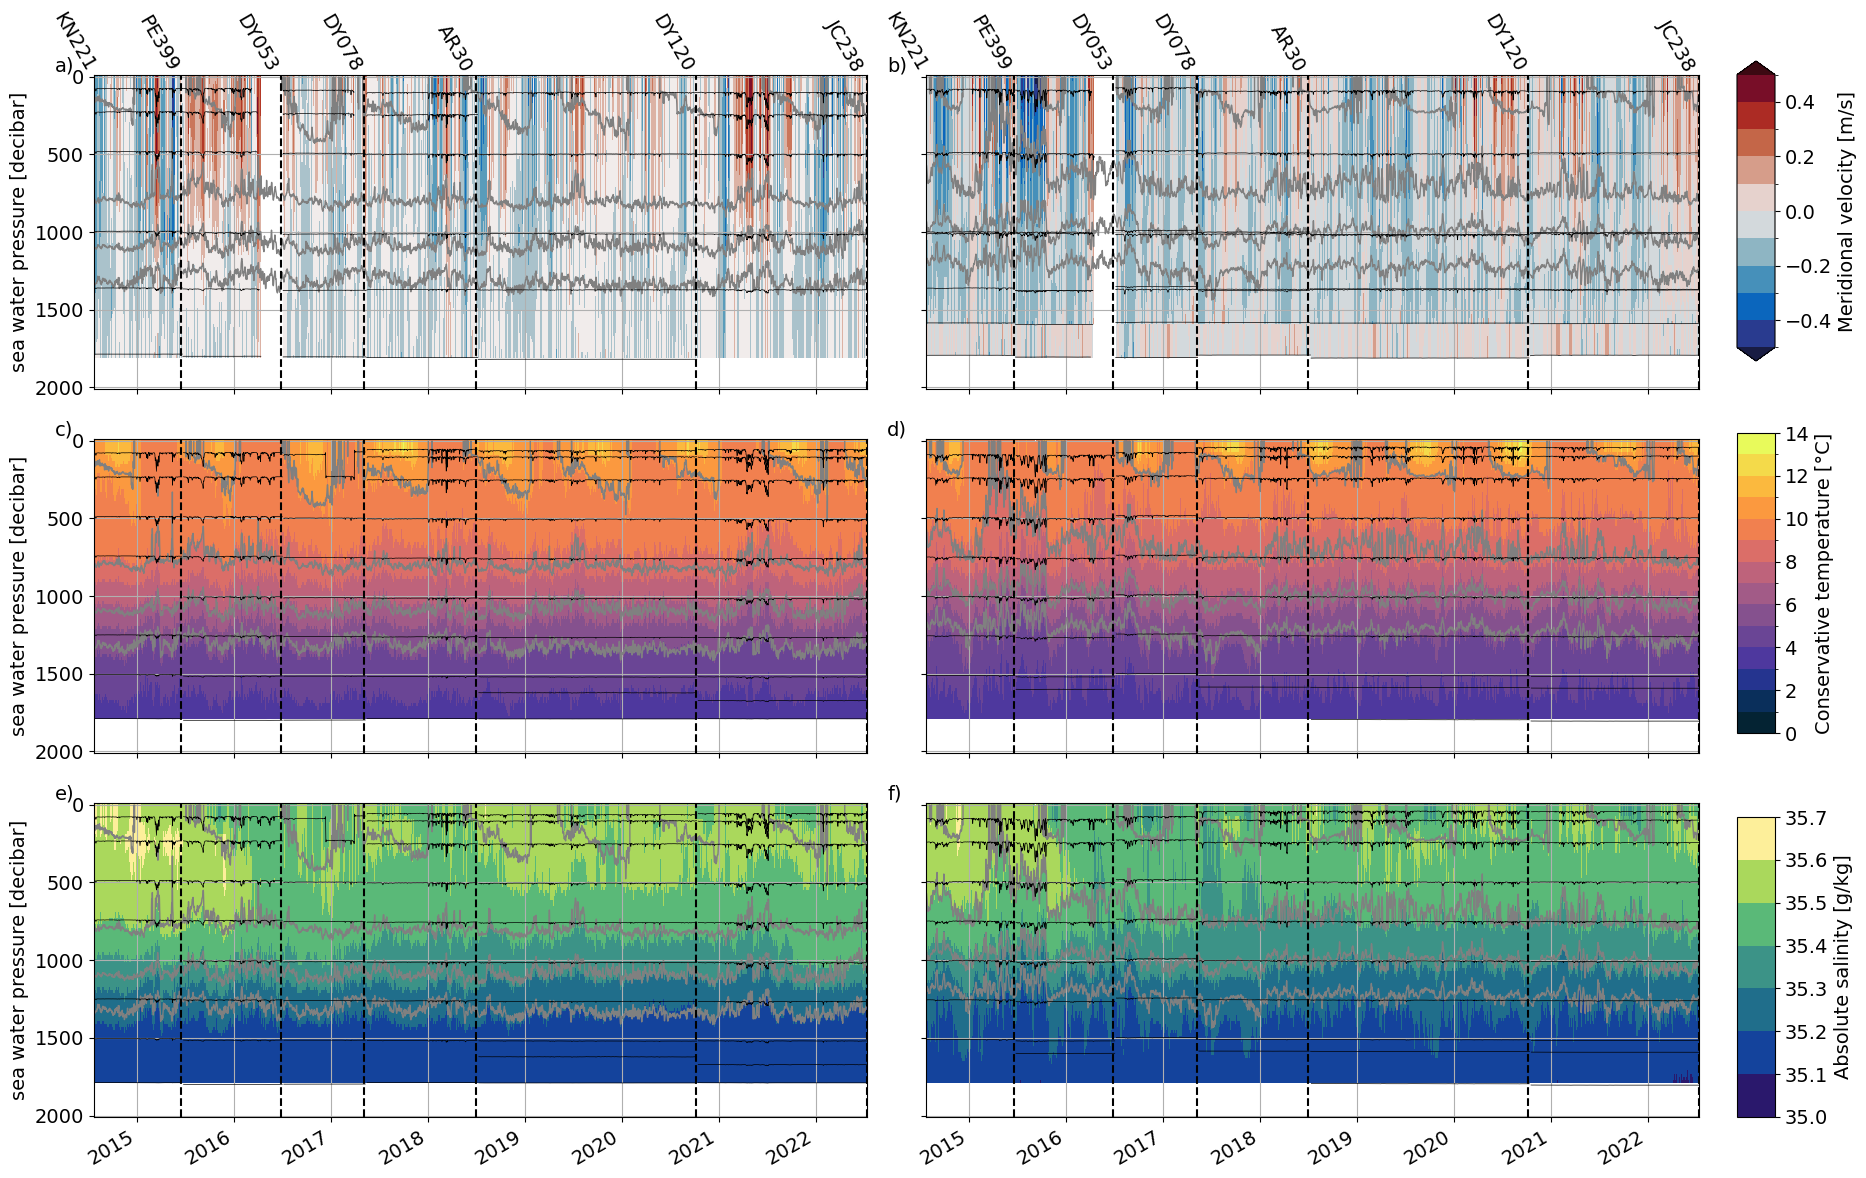

In [13]:
fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)
fig.savefig(f'{fig_out_path}RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',dpi=300,bbox_inches='tight')

In [14]:
f'{fig_out_path}RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png'

'C:/Users/sa07kb/Projects/Rockall_Trough_Transports/figures/9.0_Paper_Rockall_Trough_Results/RT_EB_WB_gridded_timeseries_2014_2022.png'

# Rockall Trough Mean Sections

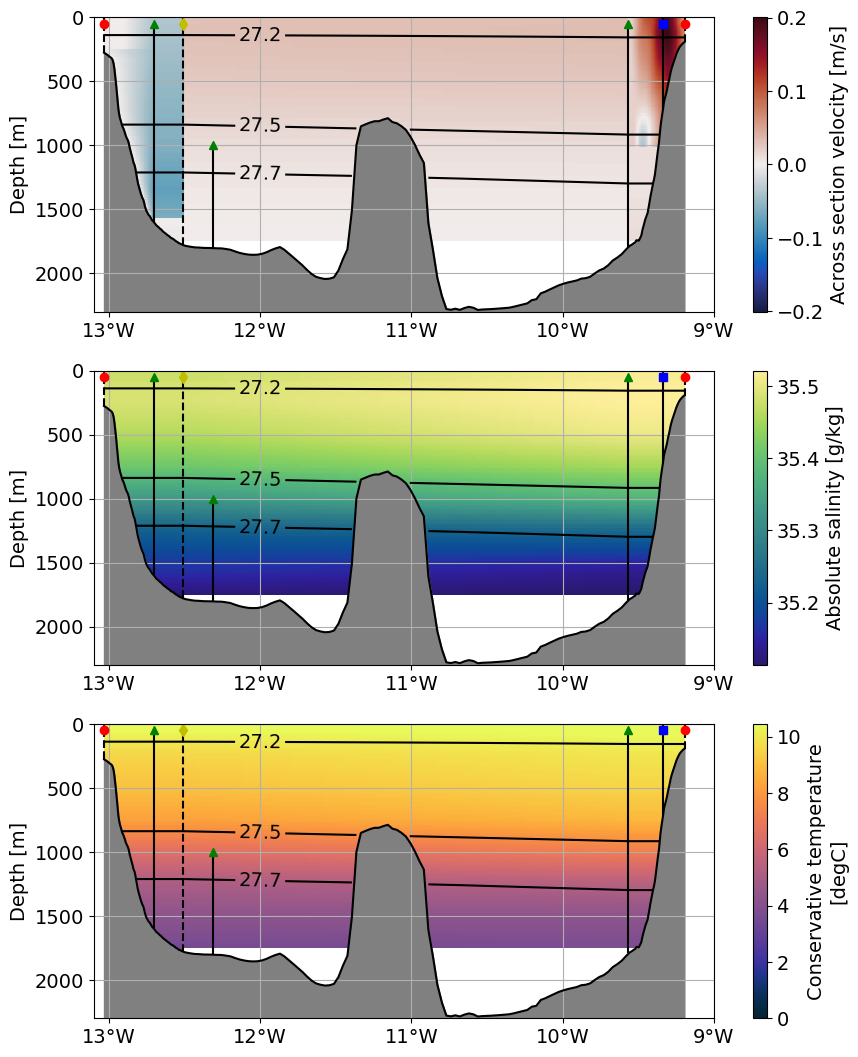

In [33]:
## figure
fig = rtv.plot_RT_mean_sections_from_mooring(ds_q_RT,ds_RT_loc)
# fig.savefig(f'{fig_out_path}Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## EW, WW and glider

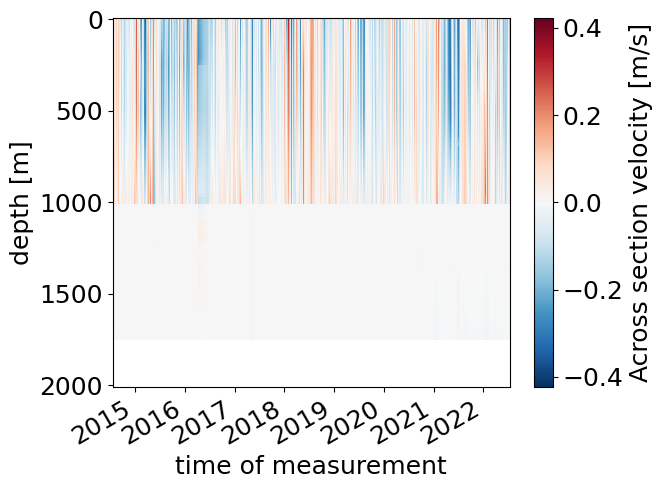

In [46]:
new = ds_q_RT.v.sel(lon=ds_q_RTEW.lon.min())
old = v_old.sel(lon=v_old.lon.min())
(new-old).plot(yincrease=False)

In [34]:
fs=18
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

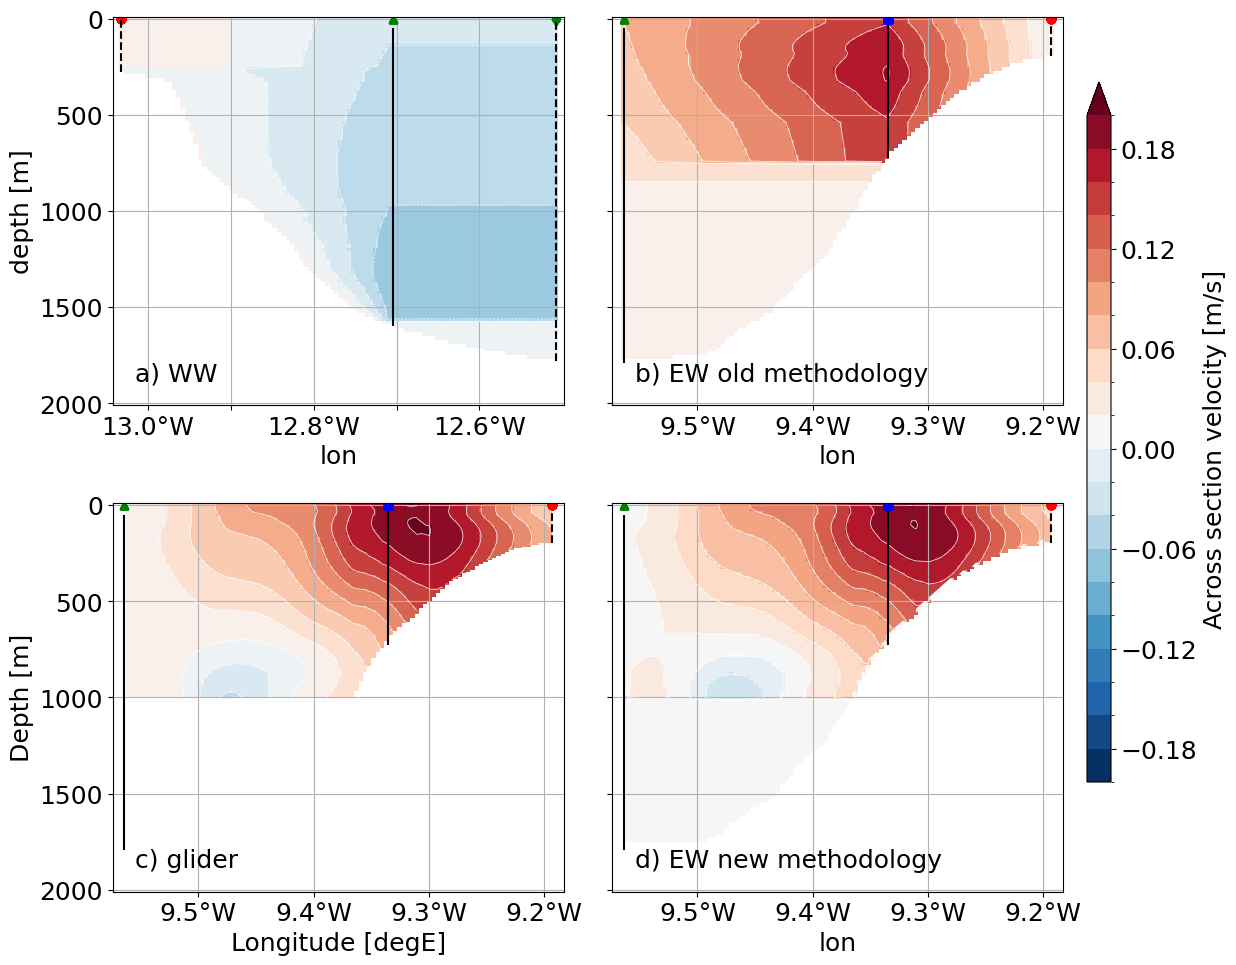

In [35]:
v_glider = ds_glider.vcur
v_glider['depth']=abs(v_glider.depth)

v_old=(ds_q_RTEW_old.q/(ds_q_RTEW_old.dx*ds_q_RTEW_old.dz))

xticks_WW = np.arange(-13.,ds_RT_loc.lon_RTWB,.1)
xticklabels_WW = ['13.0°W',' ','12.8°W',' ','12.6°W']

xticks_EW = np.arange(-9.5,ds_RT_loc.lon_RTES,.1)
xticklabels_EW = ['9.5°W','9.4°W','9.3°W','9.2°W']

fig,axs = plt.subplots(2,2,figsize=[12,10],sharey=True)

vmin,vmax,levs=-0.2,0.2,21

ax = axs[0,0]
v = ds_q_RT.v.sel(lon=ds_q_RTWW.lon).mean('time')
v.depth['long_name']='Depth'
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.plot([ds_RT_loc.lon_RTWS],[d],'or')
ax.plot([ds_RT_loc.lon_RTWB],[d],'dg')
ax.plot([ds_RT_loc.lon_RTWB1],[d],'^g')

ax.vlines(ds_RT_loc.lon_RTWB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
ax.vlines(ds_RT_loc.lon_RTWS,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
ax.vlines(ds_RT_loc.lon_RTWB1,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')

ax.set_xlim([ds_RT_loc.lon_RTWS-0.01,ds_RT_loc.lon_RTWB+0.01])
ax.set_xticks(xticks_WW)
ax.set_xticklabels(xticklabels_WW,fontsize=fs)

ax.text(0.05, 0.05,f'a) WW',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[0,1]
v = v_old.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)

ax.text(0.05, 0.05,f'b) EW old methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[1,0]
v = v_glider.mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.05, 0.05,f'c) glider',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

ax = axs[1,1]
v = ds_q_RT.v.sel(lon=ds_q_RTEW.lon).mean('time')
im_hdl = v.plot(
    x='lon',ax=ax,add_colorbar=False,yincrease=False,
    vmin=vmin,vmax=vmax,levels=levs,cmap='RdBu_r')
v.plot.contour(ax=ax,x='lon',colors='w',linewidths=.5,
               yincrease=False,
               vmin=vmin,vmax=vmax,levels=levs)
ax.text(0.05, 0.05,f'd) EW new methodology',
        transform=ax.transAxes, fontsize=fs,
         verticalalignment='bottom',horizontalalignment='left')

for i,ax in enumerate(axs.flat):
    ax.grid()
    if i>0:
        ax.vlines(ds_RT_loc.lon_RTADCP,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
        ax.vlines(ds_RT_loc.lon_RTEB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
        ax.vlines(ds_RT_loc.lon_RTES,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')

        ax.plot([ds_RT_loc.lon_RTES],[d],'or')
        ax.plot([ds_RT_loc.lon_RTADCP],[d],'sb')
        ax.plot([ds_RT_loc.lon_RTEB],[d],'^g')
        
        ax.set_xlim([ds_RT_loc.lon_RTEB-0.01,ds_RT_loc.lon_RTES+0.01])
        ax.set_xticks(xticks_EW)
        ax.set_xticklabels(xticklabels_EW,fontsize=fs)
        
    if i==1 or i==3:
        ax.set_ylabel('')
plt.tight_layout()
fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
cb =fig.colorbar(im_hdl, cax=cbar_ax)
cb.set_label('Across section velocity [m/s]')

fig.savefig(f'{fig_out_path}Rockall_Trough_WW_EW_glider_mean_section_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

# Moored vs glider reconstructed velocities

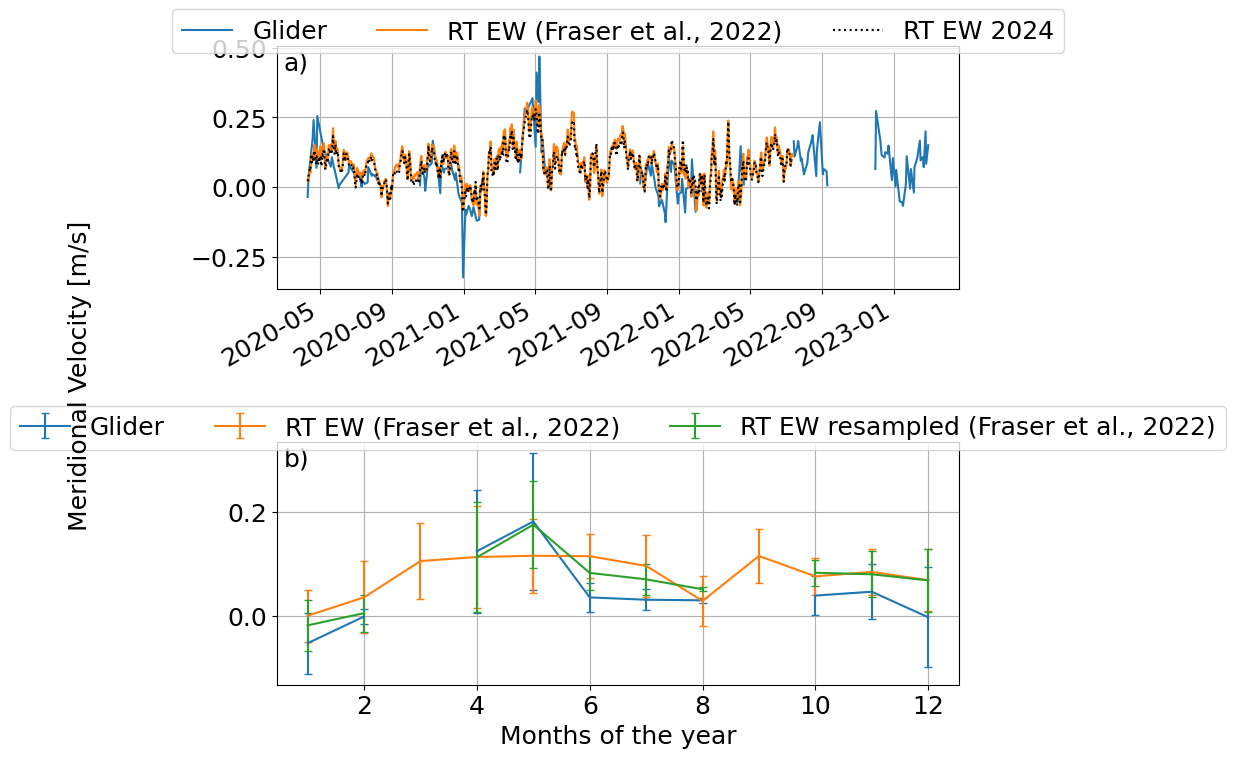

In [19]:
fig,axs = plt.subplots(2,1,figsize = [11,8])
v_moored = v_old.sel(depth=slice(None,1000) ,time=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                ).mean(['lon','depth'])
v_moored_new = ds_q_RT.v.sel(lon=ds_q_RTEW.lon,depth=slice(None,1000) ,time=slice(ds_glider.time.min().values,ds_glider.time.max().values)
                ).mean(['lon','depth'])

## subplot 1
ax = axs[0]
color='C0'
ds_glider_nan.vcur.mean(['lon','depth']).plot.line('-',ax=ax,label='Glider',color=color)
color='C1'
v_moored.plot.line('-',ax=ax,label='RT EW (Fraser et al., 2022)',color=color)
color='k'
v_moored_new.plot.line(':',ax=ax,label='RT EW 2024',color=color)
ax.set_ylabel('')
ax.set_xlabel('')
ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.2))
ax.grid()

# # suplot 2
# # select depth averaged meridional velocities
x_m = v_moored
x_g = ds_glider_nan.vcur.mean(['lon','depth'])
x_m = x_m.sel(time=slice(x_g.time.min().values,x_m.time.max().values))
x_g = x_g.sel(time=slice(x_g.time.min().values,x_m.time.max().values))

ax = axs[1]
color='C0'
m=x_g.groupby('time.month').mean(['time'])
d=x_g.groupby('time.month').std('time')
dummy = m.notnull()
ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='Glider')

color='C1'
m = x_m.groupby('time.month').mean(['time'])
d=x_m.groupby('time.month').std('time')
ax.errorbar(m.month, m, yerr=d, fmt='-', capsize=3, capthick=1, color=color,label='RT EW (Fraser et al., 2022)')

color='C2'
m = x_m.interp(time=x_g.time.values
                ).groupby('time.month').mean(['time'])
d=x_m.interp(time=x_g.time.values
                ).groupby('time.month').std('time')
ax.errorbar(m.where(dummy).month, m.where(dummy), yerr=d.where(dummy), 
            fmt='-', capsize=3, capthick=1, color=color,
            label='RT EW resampled (Fraser et al., 2022)')

ax.set_xlabel('Months of the year')
ax.legend(ncol=3,loc='upper center',bbox_to_anchor=(0.5,1.2))
ax.grid()



import string
fig.text(0.0, 0.5, 'Meridional Velocity [m/s]', va='center', rotation='vertical');
for n, ax in enumerate(axs): 
    ax.text(0.01, 0.9, f'{string.ascii_lowercase[n]})', transform=ax.transAxes, )

plt.tight_layout()

t_start = str(ds_glider.time.min().dt.strftime("%Y%m%d").values)
t_end = str(ds_glider.time.max().dt.strftime("%Y%m%d").values)
fig.savefig((f'{fig_out_path}Rockall_Trough_V_moor_vs_glider_time_series_{t_start}_{t_end}.png'),
            dpi=300,bbox_inches='tight')

In [20]:
# interpolate moored data on glider data
x_m = v_moored
x_g = ds_glider.vcur.mean(['lon','depth'])
x_m = x_m.sel(time=slice(x_g.time.min().values,x_m.time.max().values))
x_g = x_g.sel(time=slice(x_g.time.min().values,x_m.time.max().values))

x_m = x_m.interp_like(x_g)

# correlation
pearson_coef, _ = scipy.stats.pearsonr(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Pearson correlation coefficient:", pearson_coef)

spearman_coef, _ = scipy.stats.spearmanr(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Spearman correlation coefficient:", spearman_coef)

kendall_coef, _ = scipy.stats.kendalltau(x_m.where(x_m.notnull(),drop=True), x_g.where(x_m.notnull(),drop=True))
print("Kendall correlation coefficient:", kendall_coef)

Pearson correlation coefficient: 0.8171553393130253
Spearman correlation coefficient: 0.8046634577448118
Kendall correlation coefficient: 0.6314263920671244


# Transport time series

In [21]:
fs=14
font = {'weight' : 'normal',
        'size'   : fs}
plt.rc('font', **font)

## Rockall Trough Volume Transport

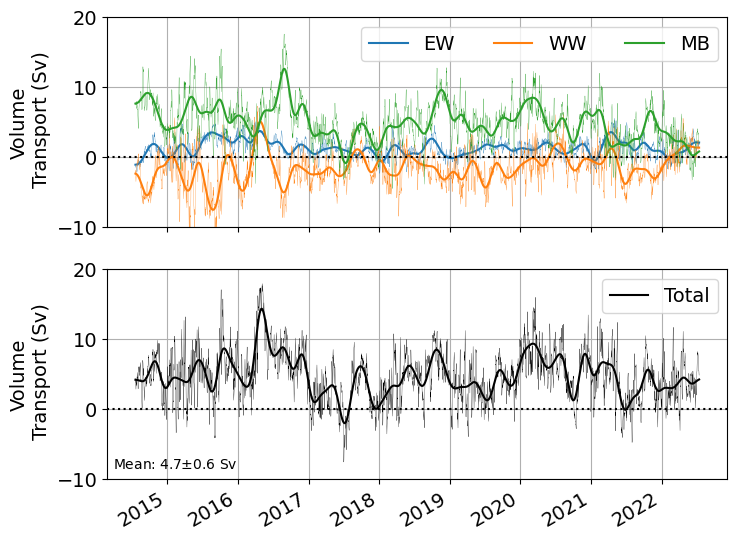

In [22]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(f'{fig_out_path}Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

In [23]:
def print_means(ds,var,var_se):
    print('%2.1f$\pm$%2.1f Sv, STD %2.1f Sv' %(
        ds[var].mean().values,ds[var_se].values,ds[var].std().values))

print('2014-2022 Total transport:')
print_means(RT_Q_Qh_Qf,'Q_tot','SE_tot') 

print('MB transport:')
print_means(RT_Q_Qh_Qf,'Q_MB','SE_MB') 

print('EW transport:')
print_means(RT_Q_Qh_Qf,'Q_EW','SE_EW') 

print('WW transport:')
print_means(RT_Q_Qh_Qf,'Q_WW','SE_WW') 

2014-2022 Total transport:
4.7$\pm$0.6 Sv, STD 3.6 Sv
MB transport:
5.0$\pm$0.5 Sv, STD 3.1 Sv
EW transport:
1.3$\pm$0.2 Sv, STD 1.3 Sv
WW transport:
-1.5$\pm$0.3 Sv, STD 2.7 Sv


In [24]:
t1,t2=None,'2020-10'

print(f'2014 to {t2} Total transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_tot','SE_tot') 

print(f'2014 to {t2} MB transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_MB','SE_MB') 

print(f'2014 to {t2} EW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_EW','SE_EW') 

print(f'2014 to {t2} WW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_WW','SE_WW') 

2014 to 2020-10 Total transport:
4.9$\pm$0.6 Sv, STD 3.7 Sv
2014 to 2020-10 MB transport:
5.4$\pm$0.5 Sv, STD 3.1 Sv
2014 to 2020-10 EW transport:
1.3$\pm$0.2 Sv, STD 1.3 Sv
2014 to 2020-10 WW transport:
-1.7$\pm$0.3 Sv, STD 2.8 Sv


In [25]:
t1,t2=None,'2018-07'

print(f'2014 to {t2} Total transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_tot','SE_tot') 

print(f'2014 to {t2} MB transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_MB','SE_MB') 

print(f'2014 to {t2} EW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_EW','SE_EW') 

print(f'2014 to {t2} WW transport:')
print_means(RT_Q_Qh_Qf.sel(TIME=slice(t1,t2)),'Q_WW','SE_WW') 

2014 to 2018-07 Total transport:
4.8$\pm$0.6 Sv, STD 3.9 Sv
2014 to 2018-07 MB transport:
5.3$\pm$0.5 Sv, STD 3.4 Sv
2014 to 2018-07 EW transport:
1.3$\pm$0.2 Sv, STD 1.4 Sv
2014 to 2018-07 WW transport:
-1.9$\pm$0.3 Sv, STD 3.0 Sv


## Rockall Trough Heat Transport

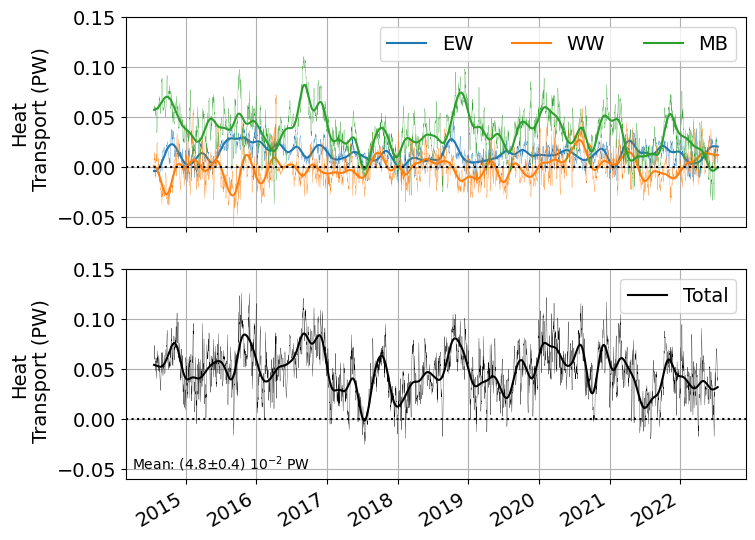

In [26]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

# fig.savefig(f'{fig_out_path}Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

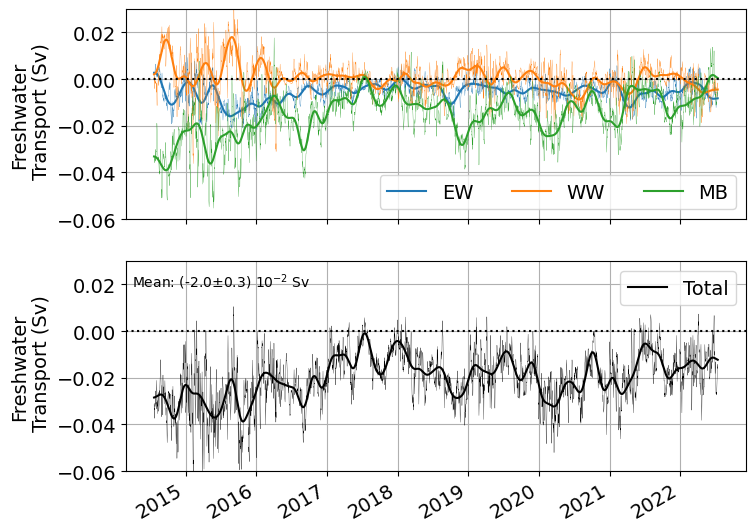

In [27]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

# fig.savefig(f'{fig_out_path}Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')

## RT z-integrated transports

In [28]:
# Compute fluxes in each cell
qh_MB,qf_MB,qS_MB = rtf.calc_fluxes(ds_q_RTMB)
qh_WW,qf_WW,qS_WW = rtf.calc_fluxes(ds_q_RTWW)
qh_EW,qf_EW,qS_EW = rtf.calc_fluxes(ds_q_RTEW)

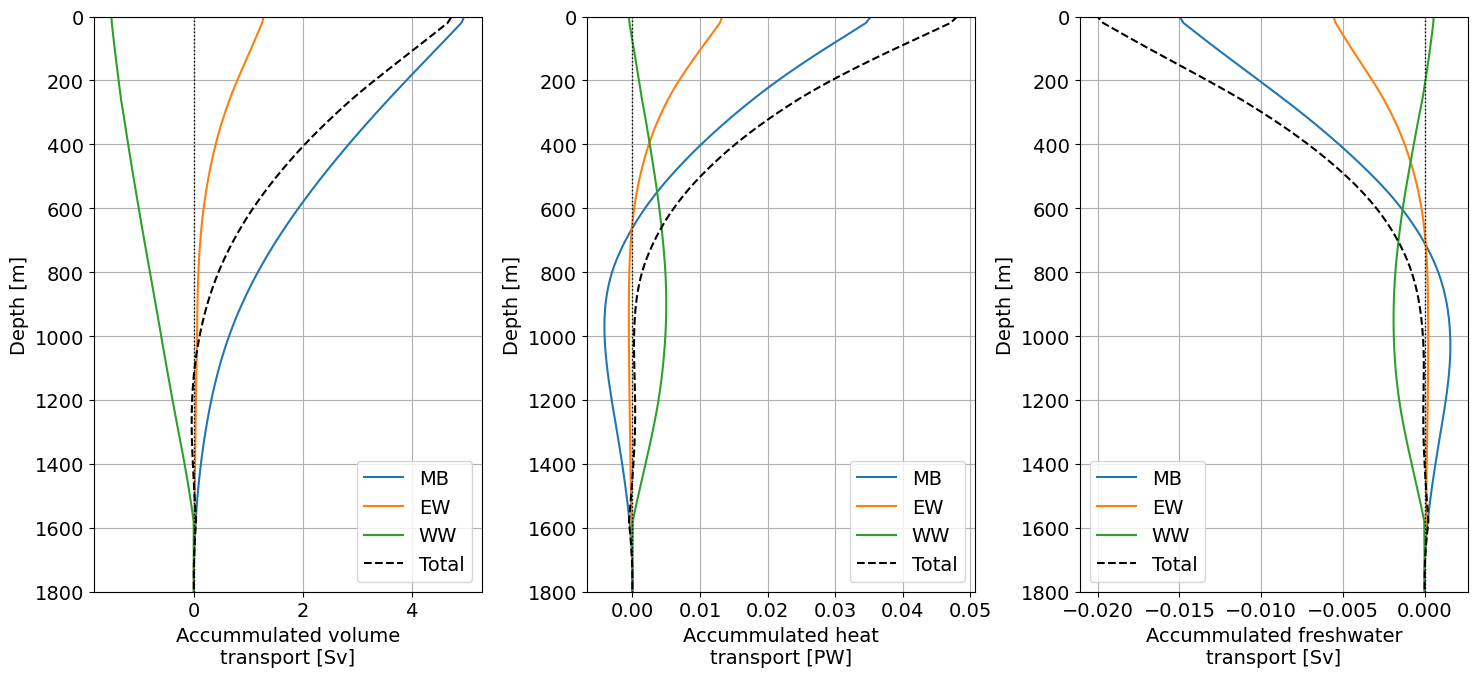

In [29]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_q_RT.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RT.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(qh_MB.sum('lon')/1e15).mean(['time']).reindex(depth=qh_MB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qh_EW.sum('lon')/1e15).mean(['time']).reindex(depth=qh_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qh_WW.sum('lon')/1e15).mean(['time']).reindex(depth=qh_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qh_MB.sum('lon')+qh_WW.sum('lon')+(qh_EW.sum('lon')))/1e15)
total.mean(['time']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(qf_MB.sum('lon')/1e6).mean(['time']).reindex(depth=qf_MB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qf_EW.sum('lon')/1e6).mean(['time']).reindex(depth=qf_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qf_WW.sum('lon')/1e6).mean(['time']).reindex(depth=qf_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qf_MB.sum('lon')+qf_WW.sum('lon')+(qf_EW.sum('lon')))/1e6)
total.mean(['time']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

# fig.savefig(f'{fig_out_path}Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_version}.png',dpi=300,bbox_inches='tight')